In [1]:
from sklearn.utils import shuffle
from collections import defaultdict
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter 
from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import pickle
import operator 
import matplotlib.pyplot as plt
import string
import pandas as pd
import numpy as np

In [2]:
def import_dataset(dir_path,label):
    my_dir_path = dir_path
    mail = defaultdict(list)
    if label == 0:
        for file in Path(my_dir_path).iterdir():
            with open(file,"r") as file_open:
                mail["file_name"] = file.name
                mail["text"].append(file_open.read())
    if label == 1:
        for file in Path(my_dir_path).iterdir():
            with open(file,"r",encoding = "latin-1") as file_open:
                mail["file_name"] = file.name
                mail["text"].append(file_open.read())
    df = pd.DataFrame(mail)
    df.drop("file_name", axis=1, inplace=True)
    df.rename(columns={'text': 'mail'}, inplace=True)
    if label == 0:
        df['status'] = 0
    if label == 1:
        df['status'] = 1
    return df

In [3]:
ham = import_dataset("D:/Sem-2/Machine Learning/Assig/enron1/ham",0)
spam = import_dataset("D:/Sem-2/Machine Learning/Assig/enron1/spam",1)

In [4]:
all_mail = pd.concat([ham, spam])
print("The dimensions of the final dataset",all_mail.shape)

The dimensions of the final dataset (5172, 2)


In [5]:
all_mail.groupby('status').describe()

mail                                                               
       count unique                                                top freq
status                                                                     
0       3672   3531  Subject: calpine daily gas nomination\n>\nrick...   20
1       1500   1463                                        Subject: \n   16

In [5]:
all_mail.drop_duplicates(inplace = True)
print("The dimensions of the final dataset",all_mail.shape)

The dimensions of the final dataset (4994, 2)


In [6]:
all_mail.isnull().sum()

mail      0
status    0
dtype: int64

In [7]:
#to shuffle
all_mail = shuffle(all_mail)
all_mail.head()

,mail,status
3283,Subject: re : fw : cowtrap allocation - 4 / 01...,0
347,"Subject: oh boy , i want this ! ydx 6 bd\npali...",1
142,Subject: suprise your spouse ! vi [ agra !\n,1
497,Subject: re : meter 8740 dec 99\nrobert and i ...,0
384,Subject: aquila header ( meter # 980072 ) - ja...,0


In [8]:
all_mail.groupby('status').describe()

mail                                                               
       count unique                                                top freq
status                                                                     
0       3531   3531  Subject: 24 x 5 products\nplease make sure thi...    1
1       1463   1463  Subject: $ 55486\nhello ,\ni sent you an email...    1

In [9]:
def process_message(mail):
    clean_mail = " "
    mail = mail.lower()
    nopunc =[char for char in mail if char not in string.punctuation]
    nopunc=''.join(nopunc)
    clean_word = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    clean_word = [w for w in clean_word if len(w) > 2]
    ps = PorterStemmer()
    clean_word = [ps.stem(word) for word in clean_word]
    for i in range(len(clean_word)):
        clean_mail = clean_mail + " "+ clean_word[i]
    return clean_mail
    #stemmer = PorterStemmer()
    #clean_word = [stemmer.stem(word) for word in clean_word]
    return clean_mail

In [10]:
all_mail["mail"]=all_mail['mail'].apply(process_message)

In [11]:
all_mail.head()

,mail,status
3283,subject cowtrap alloc believ daren farmer en...,0
347,subject boy want ydx paliourg new super viag...,1
142,subject supris spous agra,1
497,subject meter 8740 dec robert put head toget...,0
384,subject aquila header meter 980072 januari v...,0


In [12]:
#divide into training and test
mail_train,mail_test,status_train,status_test = train_test_split(all_mail['mail'],all_mail['status'],test_size=0.3)

In [13]:
def combine_Dataset(mail,status):
    dataset = pd.concat([mail,status],axis = 1)
    return dataset

In [14]:
#combine train Dataset
train_data = combine_Dataset(mail_train,status_train)
test_data = combine_Dataset(mail_test,status_test)

In [15]:
train_data['status'].value_counts()

0    2460
1    1035
Name: status, dtype: int64

In [16]:
#total num of ham and spam in test.
test_data['status'].value_counts()

0    1071
1     428
Name: status, dtype: int64

In [17]:
train_data['length']=train_data['mail'].apply(len)
train_data.head()

,mail,status,length
262,subject flow month date attach month date fl...,0,54
526,subject fyi daren hey sorri call last thur f...,0,215
184,subject order prescript ion dru onlin,1,39
28,subject evergreen deal look comment juli dar...,0,536
1539,subject mobil beaumont rebecca spoke brian n...,0,253


In [18]:
ham_mail = train_data[train_data['status'] == 0]
spam_mail = train_data[train_data['status'] == 1]

In [19]:
ham_mail.head()

,mail,status,length
262,subject flow month date attach month date fl...,0,54
526,subject fyi daren hey sorri call last thur f...,0,215
28,subject evergreen deal look comment juli dar...,0,536
1539,subject mobil beaumont rebecca spoke brian n...,0,253
1039,subject fuel per mari sitara handl either ca...,0,1231


In [20]:
def top_words(mails):
    words = mails['mail'].tolist()
    token = [word_tokenize(x) for x in words]
    words = reduce(operator.concat,token)
    top_words = dict(Counter(words).most_common(20))
    return top_words
    


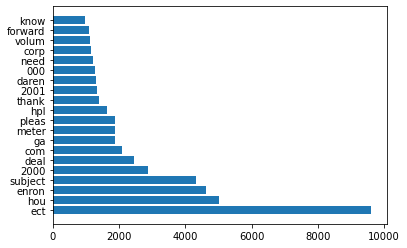

In [21]:
ham_top_words = top_words(ham_mail)
plt.barh(*zip(*ham_top_words.items()))
plt.show()

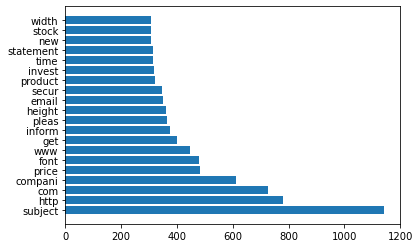

In [22]:
spam_top_words = top_words(spam_mail)
plt.barh(*zip(*spam_top_words.items()))
plt.show()

In [28]:
ham_mail.length.describe()

count     2468.000000
mean       605.987844
std        884.796237
min         24.000000
25%        148.000000
50%        317.000000
75%        746.250000
max      20327.000000
Name: length, dtype: float64

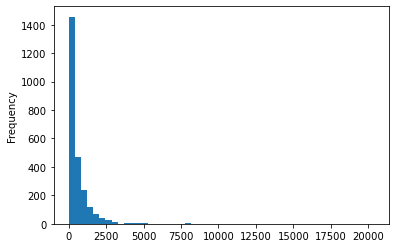

In [27]:
ham_mail['length'].plot(bins=50,kind='hist')


In [22]:
spam_mail.length.describe()

count    1020.000000
mean      114.623529
std       168.116961
min         1.000000
25%        26.000000
50%        56.000000
75%       114.000000
max      1575.000000
Name: length, dtype: float64

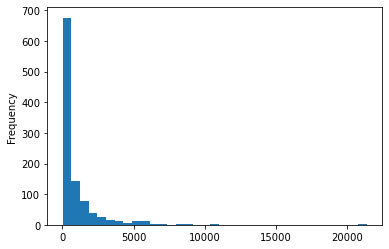

In [119]:
spam_mail['length'].plot(bins=35,kind='hist')

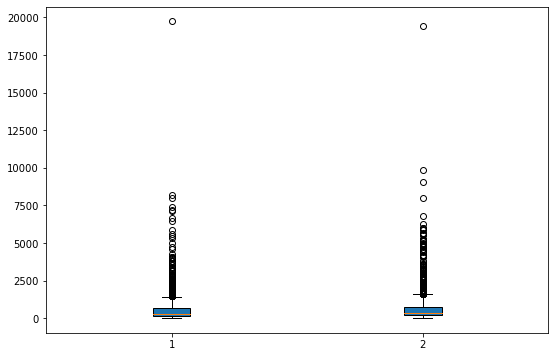

In [23]:
data = [ham_mail['length'], spam_mail['length']]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data,patch_artist=True)

In [24]:
mail_train = mail_train.to_frame()
status_train = status_train.to_frame()
mail_test = mail_test.to_frame()
status_test = status_test.to_frame()
mail_train.head()

,mail
262,subject flow month date attach month date fl...
526,subject fyi daren hey sorri call last thur f...
184,subject order prescript ion dru onlin
28,subject evergreen deal look comment juli dar...
1539,subject mobil beaumont rebecca spoke brian n...


In [25]:
mail_train.shape
last = 3495 - 2796
last
print(len(status_test))
print(len(mail_test))

1499
1499


In [ ]:
training_set_mail = mail_train[:2796]
training_set_status = status_train[:2796]
validation_set_mail = mail_train[-699:]
validation_set_status = status_train[-699:]

In [36]:
print(len(training_set_mail),len(training_set_status),len(validation_set_mail),len(validation_set_status))

2796 2796 699 699
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [27]:

tfvec = TfidfVectorizer()
tfidf_training = tfvec.fit_transform(training_set_mail['mail'])
tfidf_validation = tfvec.transform(validation_set_mail['mail'])
tfidf_test = tfvec.transform(mail_test['mail'])

In [40]:
def model_execution(model,hyperParameter,tfidf_training,training_set_status,tfidf_validation):
    classifier_tuned = RandomizedSearchCV(model,hyperParameter)
    classifier_tuned.fit(tfidf_training, training_set_status.values.ravel())
    pred = classifier_tuned.predict(tfidf_validation)
    return pred

In [ ]:
def model_evaluation(validation_set,pred):
    print(confusion_matrix(validation_set,pred))
    accuracy =accuracy_score(validation_set,pred)
    return(accuracy)

In [ ]:
def metric(validation_set_status,pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(validation_set_status,pred))
    print('Mean Squared Error:', metrics.mean_squared_error(validation_set_status,pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(validation_set_status,pred)))

In [ ]:
import pickle
def save_model_to_disk(model,filename):
    #filename = 'finalized_model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [32]:

hyperParameter = {'alpha': np.linspace(0.5, 1.5, 6),'fit_prior': [True, False]}
model = MultinomialNB()
classifierMNB_tuned = RandomizedSearchCV(model, hyperParameter)
classifierMNB_tuned.fit(tfidf_training, training_set_status.values.ravel())
pred = classifierMNB_tuned.predict(tfidf_validation)
#print(classification_report(status_train ,pred ))
print(confusion_matrix(validation_set_status,pred))
print(accuracy_score(validation_set_status,pred))


[[492   6]
 [ 11 190]]
0.9756795422031473


In [31]:
from scipy.stats import reciprocal, uniform
hyperParameter = {'C': uniform(1, 10),  
              'gamma': reciprocal(0.001, 0.1), 
              'kernel': ['rbf'],
                 'shrinking': [True,False],
                 'probability':[True,False],
                 'degree':[2,3,4]}
model = SVC()
classifierSVC_tuned = RandomizedSearchCV(model, hyperParameter)
classifierSVC_tuned.fit(tfidf_training, training_set_status.values.ravel())
pred = classifierSVC_tuned.predict(tfidf_validation)
#print(classification_report(status_train ,pred ))
print(confusion_matrix(validation_set_status,pred))
print(accuracy_score(validation_set_status,pred))

[[488  10]
 [  1 200]]
0.9842632331902719


In [151]:
RF default

[[469  12]
 [  5 213]]
0.9756795422031473


In [33]:
hyperParameter = {'bootstrap': [True, False],
 'max_depth': [10, 20,None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [5, 10],
 'n_estimators': [200, 400, 600]}
model = RandomForestClassifier()
classifierRF_tuned = RandomizedSearchCV(model,hyperParameter)
classifierRF_tuned.fit(tfidf_training, training_set_status.values.ravel())
pred = classifierRF_tuned.predict(tfidf_validation)
#print(classification_report(status_train ,pred ))
print(confusion_matrix(validation_set_status,pred))
print(accuracy_score(validation_set_status,pred))

[[489   9]
 [  8 193]]
0.9756795422031473


In [37]:
hyperParameter = {"max_depth": np.linspace(1, 32, 32, endpoint=True),
                  "min_samples_split": np.linspace(0.1, 1.0, 5, endpoint=True),
              "max_features": list(range(1,100))
              }
model = DecisionTreeClassifier()
pred_DT = model_execution(model,hyperParameter,tfidf_training,training_set_status,tfidf_validation)

In [39]:
model_evaluation(validation_set_status,pred_DT)

[[380 118]
 [ 13 188]]
0.8125894134477826


In [30]:
hyperParameter = {"max_depth": np.linspace(1, 32, 32, endpoint=True),
                  "min_samples_split": np.linspace(0.1, 1.0, 5, endpoint=True),
              "max_features": list(range(1,100))
              }
model = DecisionTreeClassifier()
#print(model.get_params().keys())
classifierDT_tuned = RandomizedSearchCV(model,hyperParameter)
classifierDT_tuned.fit(tfidf_training, training_set_status)
pred = classifierDT_tuned.predict(tfidf_validation)
#print(classification_report(status_train ,pred ))
print(confusion_matrix(validation_set_status,pred))
print(accuracy_score(validation_set_status,pred))


[[484  14]
 [156  45]]
0.7567954220314735


In [224]:
metric(validation_set_status,pred)

Mean Absolute Error: 0.20314735336194564
Mean Squared Error: 0.20314735336194564
Root Mean Squared Error: 0.4507187075792901


In [225]:
pred = classifierSVC_tuned.predict(tfidf_test)
#print(classification_report(status_train ,pred ))
print(confusion_matrix(status_test,pred))
print(accuracy_score(status_test,pred))

[[1048   15]
 [   6  430]]
0.9859906604402935
